In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
from os.path import isfile, join
from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils
from src.data import MontevideoFoldersDataset, MontevideoFoldersDataset_w_time, PatchesFoldersDataset_w_geodata

#Deep Learning
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

import random
from src.dl_models.unet import UNet, UNet2
from src.lib.latex_options import Colors, Linestyles


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
dataset = 'region3'

In [5]:
# FRAME_OUT = 6
# OUTPUT_LAST = True

# if FRAME_OUT == 6:
#     MODEL_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/R3/60min' + \
#         '/60min_UNET2_region3_mae_filters16_sigmoid_diffFalse_retrainFalse_52_12-02-2022_21:30_BEST_FINAL.pt'
# elif FRAME_OUT == 12:
#     MODEL_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/R3/120min' + \
#         '/120min_UNET2_region3_mae_filters16_sigmoid_diffFalse_retrainFalse_29_12-02-2022_19:40_BEST_FINAL.pt'
# elif FRAME_OUT == 18:
#     MODEL_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/R3/180min' +\
#         '/180min_UNET2_region3_mae_filters16_sigmoid_diffFalse_retrainFalse_20_12-02-2022_07:46_BEST_FINAL.pt' 
# elif FRAME_OUT == 24:
#     MODEL_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/R3/240min' +\
#         '/240min_UNET2_region3_mae_filters16_sigmoid_diffFalse_retrainFalse_21_17-02-2022_02:26_BEST_FINAL.pt'
# elif FRAME_OUT == 30:
#     MODEL_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/R3/300min' + \
#         '/300min_UNET2_region3_mae_filters16_sigmoid_diffFalse_retrainFalse_13_14-02-2022_19:05_BEST_FINAL.pt'

# OUTPUT_ACTIVATION = 'sigmoid'    

# model = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
#               output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
# model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu'))["model_state_dict"])
# model.eval()

In [6]:
FRAME_OUT = 30
OUTPUT_LAST = False

MODEL_60_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/R3/60min' + \
    '/60min_UNET2_region3_mae_filters16_sigmoid_diffFalse_retrainFalse_52_12-02-2022_21:30_BEST_FINAL.pt'

MODEL_120_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/R3/120min' + \
    '/120min_UNET2_region3_mae_filters16_sigmoid_diffFalse_retrainFalse_29_12-02-2022_19:40_BEST_FINAL.pt'

MODEL_180_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/R3/180min' +\
    '/180min_UNET2_region3_mae_filters16_sigmoid_diffFalse_retrainFalse_20_12-02-2022_07:46_BEST_FINAL.pt' 

MODEL_240_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/R3/240min' +\
    '/240min_UNET2_region3_mae_filters16_sigmoid_diffFalse_retrainFalse_21_17-02-2022_02:26_BEST_FINAL.pt'

MODEL_300_PATH = '/clusteruy/home03/DeepCloud/deepCloud/checkpoints/R3/300min' + \
    '/300min_UNET2_region3_mae_filters16_sigmoid_diffFalse_retrainFalse_13_14-02-2022_19:05_BEST_FINAL.pt'

OUTPUT_ACTIVATION = 'sigmoid'    

model_60 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
model_60.load_state_dict(torch.load(MODEL_60_PATH, map_location=torch.device('cpu'))["model_state_dict"])
model_60.eval()

model_120 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
model_120.load_state_dict(torch.load(MODEL_120_PATH, map_location=torch.device('cpu'))["model_state_dict"])
model_120.eval()

model_180 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
model_180.load_state_dict(torch.load(MODEL_180_PATH, map_location=torch.device('cpu'))["model_state_dict"])
model_180.eval()

model_240 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
model_240.load_state_dict(torch.load(MODEL_240_PATH, map_location=torch.device('cpu'))["model_state_dict"])
model_240.eval()

model_300 = UNet2(n_channels=3,n_classes=1, bilinear=True, p=0,
              output_activation=OUTPUT_ACTIVATION, bias=False, filters=16).to(device)
model_300.load_state_dict(torch.load(MODEL_300_PATH, map_location=torch.device('cpu'))["model_state_dict"])
model_300.eval()

print('Done.')

Done.


In [7]:
CSV_PATH = '/clusteruy/home03/DeepCloud/deepCloud/data/region3/test_cosangs_region3.csv'
normalize = preprocessing.normalize_pixels(mean0 = False) #values between [0,1]

val_mvd = MontevideoFoldersDataset_w_time(
                                            path='/clusteruy/home03/DeepCloud/deepCloud/data/' + dataset + '/test/',
                                            in_channel=3,
                                            out_channel=FRAME_OUT,
                                            min_time_diff=5,
                                            max_time_diff=15,
                                            csv_path=CSV_PATH,
                                            transform=normalize,
                                            output_last=OUTPUT_LAST
                                            )

val_loader = DataLoader(val_mvd, batch_size=1, shuffle=True)
iterator = iter(val_loader)

In [8]:
def show_seq_and_pred(sequence_array, time_list, prediction_t, fig_name=None, grid=True):
    """ Shows the images passed in a grid
    Args:
        sequence_array (array)
    """
    nbof_frames = sequence_array.shape[0]
    if np.max(sequence_array[0]) > 1.1:
        vmax = 100
    else:
        vmax = 1
    
    fontsize = 22 # 22 generates the font more like the latex text
    
    # plt.figure(figsize=(25, 5))
    fig, ax = plt.subplots(1, nbof_frames, figsize=(6 * nbof_frames, 5))

    for i in range(nbof_frames):
        if i < nbof_frames - 2:
            ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            input_nbr = i - (nbof_frames - 3)
            ax[i].set_title(f'{time_list[i]}')
            ax[i].grid(grid)


        if i == nbof_frames - 2:
            im = ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            cbar = plt.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
            ax[i].set_title(f'{time_list[-1]}')
            ax[i].grid(grid)

        if i == nbof_frames - 1:
            im = ax[i].imshow(sequence_array[i], vmin=0, vmax=vmax)
            cbar = plt.colorbar(im, ax=ax[i], fraction=0.046, pad=0.04)
            ax[i].set_title(f'{time_list[-1]}')
            ax[i].grid(grid)

        if nbof_frames == 5:
            line = plt.Line2D((.59, .59),(.1, 1), linewidth=3)
        else:
            line = plt.Line2D((.515, .515),(.1, 1), linewidth=3)
        fig.add_artist(line)

    plt.show()

In [9]:
# in_frames, out_frames, in_time, out_time = next(iterator)
# timestamp = out_time[0, 0]

# with torch.no_grad():
#     in_frames = in_frames.to(device=device)
#     out_frames = out_frames.to(device=device)
#     frames_pred = model(in_frames)
    
# in_time = in_time[0].numpy()
# print('day:', int(in_time[0,0]))

# t_6 = str(int(timestamp[1].numpy())).zfill(2) + ':' + str(int(timestamp[2].numpy())).zfill(2)
# t__2 = str(int((in_time[0][1]))).zfill(2) + ':' + str(int((in_time[0][2]))).zfill(2)
# t__1 = str(int((in_time[1][1]))).zfill(2) + ':' + str(int((in_time[1][2]))).zfill(2)
# t_0 = str(int((in_time[2][1]))).zfill(2) + ':' + str(int((in_time[2][2]))).zfill(2)

# time_list = [t__2, t__1, t_0, t_6]

# sequence_array = np.array([in_frames[0][0].cpu().numpy(),
#                            in_frames[0][1].cpu().numpy(),
#                            in_frames[0][2].cpu().numpy(),
#                            out_frames[0][0].cpu().numpy(),
#                            frames_pred[0, 0].cpu().numpy()])
# # fig_name = 'example.pdf'


# show_seq_and_pred(sequence_array,
#                   time_list=time_list,
#                   prediction_t=3,
#                   fig_name=None,
#                   grid=True)

day: 288


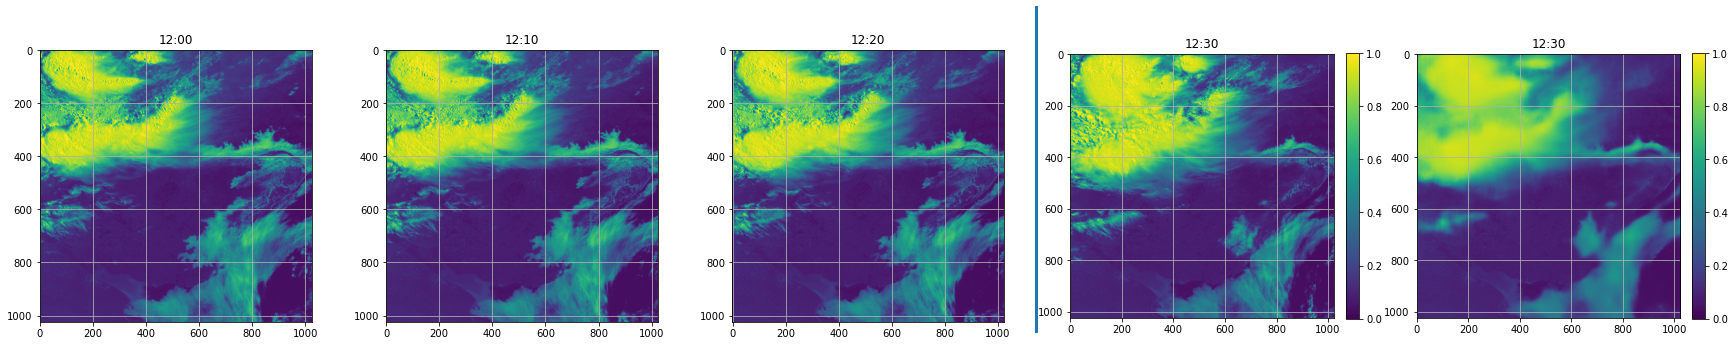

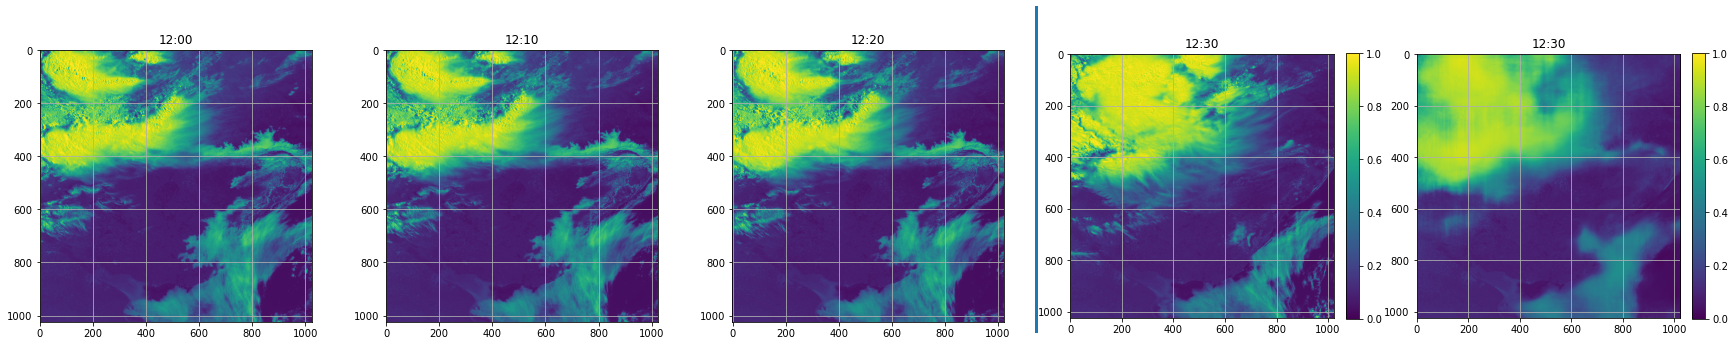

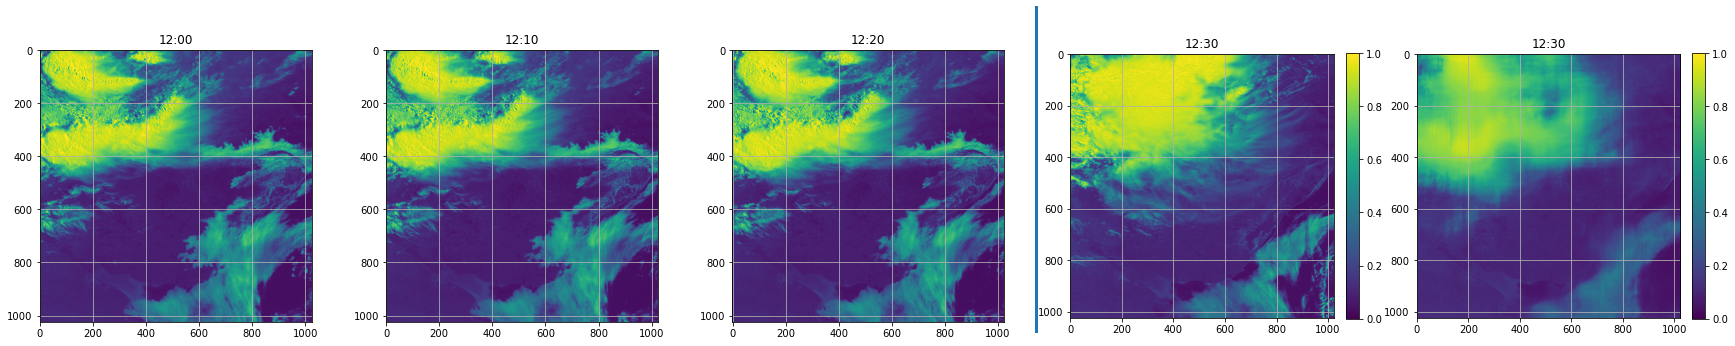

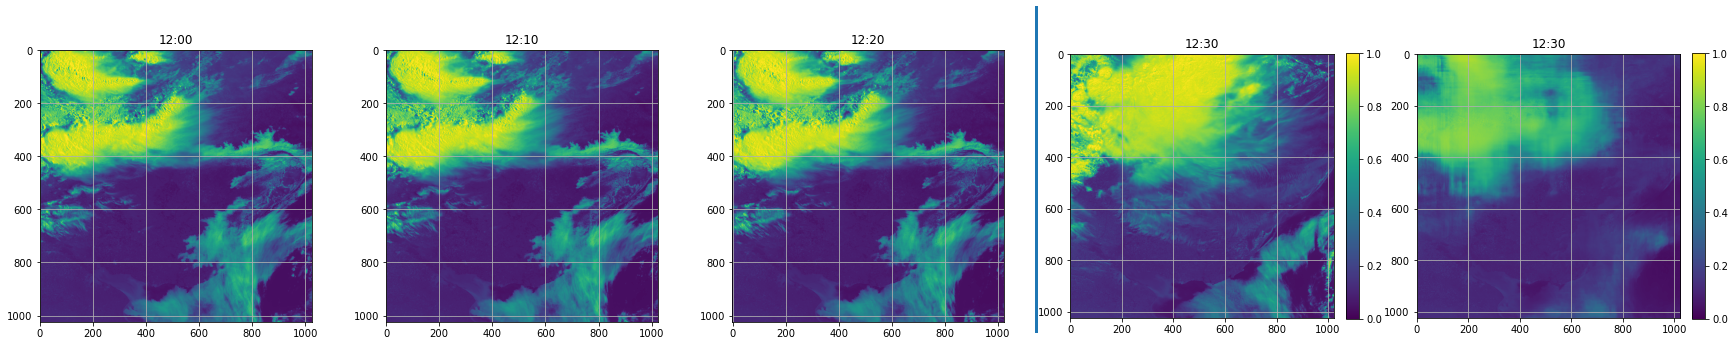

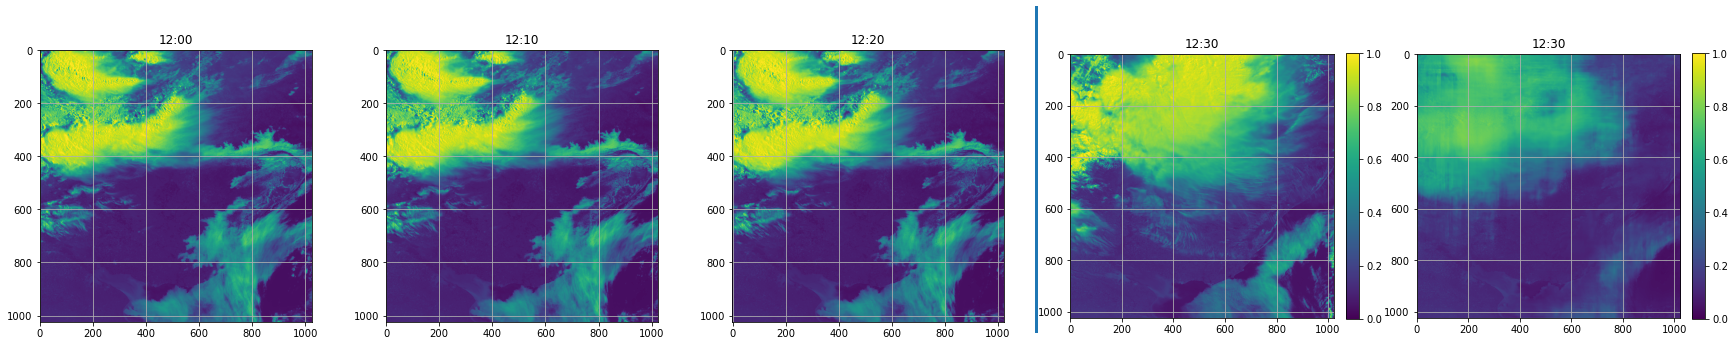

In [10]:
in_frames, out_frames, in_time, out_time = next(iterator)
timestamp = out_time[0, 0]

with torch.no_grad():
    in_frames = in_frames.to(device=device)
    out_frames = out_frames.to(device=device)
    frames_pred_60 = model_60(in_frames)
    frames_pred_120 = model_120(in_frames)
    frames_pred_180 = model_180(in_frames)
    frames_pred_240 = model_240(in_frames)
    frames_pred_300 = model_300(in_frames)
    
in_time = in_time[0].numpy()
print('day:', int(in_time[0,0]))

t_6 = str(int(timestamp[1].numpy())).zfill(2) + ':' + str(int(timestamp[2].numpy())).zfill(2)
t__2 = str(int((in_time[0][1]))).zfill(2) + ':' + str(int((in_time[0][2]))).zfill(2)
t__1 = str(int((in_time[1][1]))).zfill(2) + ':' + str(int((in_time[1][2]))).zfill(2)
t_0 = str(int((in_time[2][1]))).zfill(2) + ':' + str(int((in_time[2][2]))).zfill(2)

time_list = [t__2, t__1, t_0, t_6]

sequence_array_60 = np.array([in_frames[0][0].cpu().numpy(),
                           in_frames[0][1].cpu().numpy(),
                           in_frames[0][2].cpu().numpy(),
                           out_frames[0][5].cpu().numpy(),
                           frames_pred_60[0, 0].cpu().numpy()])

sequence_array_120 = np.array([in_frames[0][0].cpu().numpy(),
                           in_frames[0][1].cpu().numpy(),
                           in_frames[0][2].cpu().numpy(),
                           out_frames[0][11].cpu().numpy(),
                           frames_pred_120[0, 0].cpu().numpy()])

sequence_array_180 = np.array([in_frames[0][0].cpu().numpy(),
                           in_frames[0][1].cpu().numpy(),
                           in_frames[0][2].cpu().numpy(),
                           out_frames[0][17].cpu().numpy(),
                           frames_pred_180[0, 0].cpu().numpy()])

sequence_array_240 = np.array([in_frames[0][0].cpu().numpy(),
                           in_frames[0][1].cpu().numpy(),
                           in_frames[0][2].cpu().numpy(),
                           out_frames[0][23].cpu().numpy(),
                           frames_pred_240[0, 0].cpu().numpy()])

sequence_array_300 = np.array([in_frames[0][0].cpu().numpy(),
                           in_frames[0][1].cpu().numpy(),
                           in_frames[0][2].cpu().numpy(),
                           out_frames[0][29].cpu().numpy(),
                           frames_pred_300[0, 0].cpu().numpy()])

show_seq_and_pred(sequence_array_60,
                  time_list=time_list,
                  prediction_t=3,
                  fig_name=None,
                  grid=True)
show_seq_and_pred(sequence_array_120,
                  time_list=time_list,
                  prediction_t=3,
                  fig_name=None,
                  grid=True)
show_seq_and_pred(sequence_array_180,
                  time_list=time_list,
                  prediction_t=3,
                  fig_name=None,
                  grid=True)
show_seq_and_pred(sequence_array_240,
                  time_list=time_list,
                  prediction_t=3,
                  fig_name=None,
                  grid=True)
show_seq_and_pred(sequence_array_300,
                  time_list=time_list,
                  prediction_t=3,
                  fig_name=None,
                  grid=True)